In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Conditional Latent Diffusion Training

In this notebook, we will train a simple `LatentDiffusionConditional` model in low resolution (64 by 64).

The training should take about 20 hours for reasonable results.

---

Maps dataset from the pix2pix paper:
```bash
wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
tar -xvf maps.tar.gz
```

In [1]:
!pip install einops pytorch_lightning diffusers==0.12.1 kornia librosa accelerate

In [1]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import pytorch_lightning as pl

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os

from src import *

mpl.rcParams['figure.figsize'] = (8, 8)

/Users/aleksander/opt/anaconda3/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/aleksander/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so, 6): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/aleksander/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /Users/aleksander/opt/anaconda3/lib/python3.9/site-packages/torch/lib/libc10.dylib
 in /Users/aleksander/opt/anaconda3/lib/python3.9/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extension: {e}")
2023-04-17 17:15:04.098921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


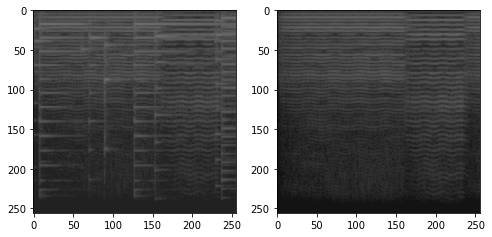

In [2]:
from dataset import SpectrogramDataset
import torchvision.transforms as T
import PIL

train_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/ins3',
                            condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/train/mix',
                            return_pair=True
                     )


valid_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/ins3',
                          condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/val/mix',
                          return_pair=True
                     )

test_ds=SpectrogramDataset(target_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/ins3',
                           condition_dir='datasets/randomMIDI/PianoViolin11025/WAV/test/mix',
                           return_pair=True
                     )

img1,img2=train_ds[0]

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

### Model Training

In [3]:
model=LatentDiffusionConditional(train_ds,
                                 valid_dataset=valid_ds,
                                 lr=1e-4,
                                 batch_size=2,
                                 schedule='cosine')

Is Time embed used ?  True


...but first, let's check if the used `AutoEncoder` (`model.ae`) can reconstruct our samples well.

**You should always test your autoencoder in this way when using latent diffusion models on a new dataset.**

Text(0.5, 1.0, 'AutoEncoder Reconstruction')

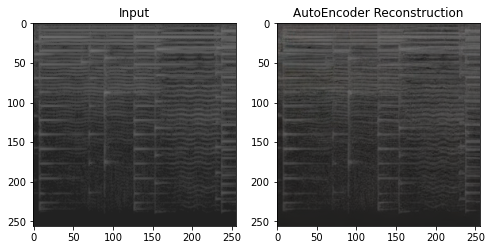

In [4]:
plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(model.ae(img1.unsqueeze(0))[0].detach().cpu().permute(1,2,0))
plt.title('AutoEncoder Reconstruction')

In [6]:
trainer = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model)

Missing logger folder: /Users/aleksander/Documents/Skole/Masteroppgave/DiffusionFastForward/lightning_logs

  | Name  | Type                                 | Params
---------------------------------------------------------------
0 | ae    | AutoEncoder                          | 83.7 M
1 | model | DenoisingDiffusionConditionalProcess | 56.6 M
---------------------------------------------------------------
140 M     Trainable params
0         Non-trainable params
140 M     Total params
561.105   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [ ]:
#trainer.fit(model, ckpt_path='lightning_logs/version_6/checkpoints/epoch=1177-step=37725.ckpt')
model = torch.load('lightning_logs/version_6/checkpoints/epoch=1177-step=37725.ckpt')

In [8]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)

#model.cuda()
out=model(batch_input, verbose=True)

diffusion sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

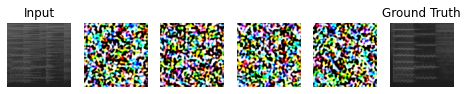

In [9]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')

In [11]:
phase = test_ds.get_phase(0)
name = test_ds.files[0]
test_ds.save_audio(out[0], phase)

array([ 3.4164646e+08, -2.0350557e+08, -6.1677408e+08, ...,
       -8.7047758e+04,  5.8114775e+05,  1.8990194e+05], dtype=float32)

By default, the `DDPM` sampler contained in the model is used, as above.

However, you can use a `DDIM` sampler just as well to reduce the number of inference steps:

In [ ]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)
STEPS=200 # ddim steps

ddim_sampler=DDIM_Sampler(STEPS,model.model.num_timesteps)

model.cuda()
out=model(batch_input,sampler=ddim_sampler,verbose=True)

In [ ]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')